## 04. PyTorch Custom Datasets

=> get own data into pytorch

### 0. Importing and setting up

In [1]:
import torch
from torch import nn

In [2]:
device = "gpu" if torch.cuda.is_available() \
    else "mps" if torch.backends.mps.is_built() else "cpu"
device

'mps'

### 1. Get data

- `Food-101 Dataset:` https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/
    - 101 different classes of food
    - 1000 images per class (750 training)

#### => use a subset of the Food-101 dataset
- use 3 classes of food 
- obly 10% of the images (75 training)

In [3]:
import requests
import zipfile
from pathlib import Path

In [4]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(image_path, " directory already exists...")
else:
    print(image_path, " does not exist, creating...")
    image_path.mkdir(parents=True, exist_ok=True)


with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading...")
    f.write(request.content)

# unzip the file data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi  directory already exists...
Downloading...
Unzipping...


### 2. Data preparation and data exploration

In [5]:
import os

def walk_through_dir(dir_path):
    """ walks through dir_path returning its contents """
    # directory tree generator
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print("There are", len(dirnames), "directories and ", len(filenames), " images in", dirpath)


In [6]:
walk_through_dir(image_path)

There are 2 directories and  0  images in data/pizza_steak_sushi
There are 3 directories and  0  images in data/pizza_steak_sushi/test
There are 0 directories and  19  images in data/pizza_steak_sushi/test/steak
There are 0 directories and  31  images in data/pizza_steak_sushi/test/sushi
There are 0 directories and  25  images in data/pizza_steak_sushi/test/pizza
There are 3 directories and  0  images in data/pizza_steak_sushi/train
There are 0 directories and  75  images in data/pizza_steak_sushi/train/steak
There are 0 directories and  72  images in data/pizza_steak_sushi/train/sushi
There are 0 directories and  78  images in data/pizza_steak_sushi/train/pizza


- `pizza_steak_sushi` -> overall dataset folder
    - `train`   -> training images
        - `pizza`   -> class name as folder name
        - `steak`
        - `sushi`
    - `test`    -> testing images

In [7]:
# set up train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

#### 2.1 Visualize images

- (1) get all of the image paths
- (2) pick a random image path using Python's `random.choice()`
- (3) get the image class name using `pathlib.Path.parent.stem`
- (4) open the image using Python `PIL(pillow)`
- (5) show image and print metadata

In [10]:
# visualize random image
import random
from PIL import Image

# get all the image path
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg')]

Random image path is: data/pizza_steak_sushi/train/steak/1257104.jpg
Image class is: steak
Image width is: 512
Image height is: 341


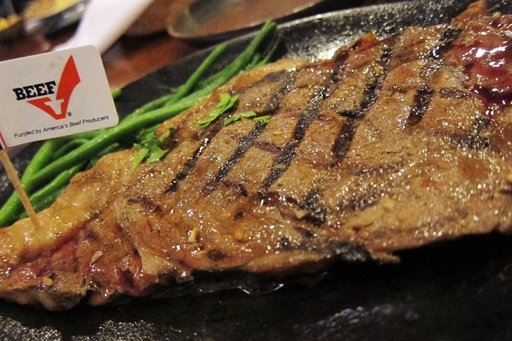

In [13]:
# pick a random image
random_image_path = random.choice(image_path_list)

# get class
image_class = random_image_path.parent.stem

# open image
img = Image.open(random_image_path)

# print metadata
print("Random image path is:", random_image_path)
print("Image class is:", image_class)
print("Image width is:", img.width)
print("Image height is:", img.height)

img

(-0.5, 511.5, 340.5, -0.5)

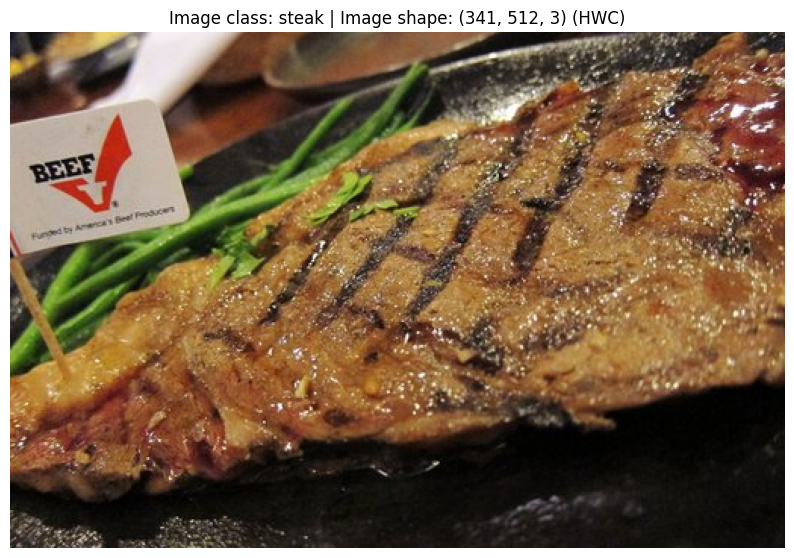

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# turn the image into an array
img_array = np.array(img)

# plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_array)
plt.title(f"Image class: {image_class} | Image shape: {img_array.shape} (HWC)")
plt.axis(False)